**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***

# Part II: Agents

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebooks**: [guides/router_agents_guide.ipynb](guides/agents_guide.ipynb) and [guides/tool_agents_guide.ipynb](guides/tool_agents_guide.ipynb)


***
<br>

* Play around with the agent systems in the guides. Maybe try to create a similar system with new nodes? Or you can try to add new tools to the existing tool-using agent system.

* Remember to include some reflections on your results. Are there, for example, any hyperparameters that are particularly important?

* You should follow the steps given in the `router_agents_guide` notebook or the `tool_agents_guide` notebook to create your own agent system - or try to optimize the existing ones.

<br>

***

In [109]:
# built-in libraries
from typing import Literal, TypedDict,  Any, Optional

# langgraph libraries
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.graph import  MermaidDrawMethod

# misc libraries
from pydantic import Field
from IPython.display import Image
from decouple import config
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from tqdm import tqdm
from sklearn.metrics import f1_score

# local modules
from src.llm import LLMCaller

In [110]:
WX_API_KEY = config("WX_API_KEY")
WX_PROJECT_ID = config("WX_PROJECT_ID")
WX_API_URL = "https://us-south.ml.cloud.ibm.com"

In [111]:
model = LLMCaller(
    api_key=WX_API_KEY,
    project_id=WX_PROJECT_ID,
    api_url=WX_API_URL,
    model_id="watsonx/ibm/granite-3-2-8b-instruct",
    params={
        GenParams.TEMPERATURE: 0.7,
        GenParams.TOP_P: 0.5, 
        GenParams.MAX_NEW_TOKENS: 50,
    }
)

In [112]:
response = model.invoke(prompt="Write a haiku about a fish")

response

BaseResponse(answer="Silent swimmer glides,\nIn ocean currents, quiet ride,\nNature's lullaby.")

In [113]:
class EmailState(TypedDict):

    email: dict[str, Any]  # The email being processed - Contains subject, sender, body, etc.
    email_category: Optional[str]  # Category of the email (e.g., work, personal, etc.
    spam_reason: Optional[str]  # Reason for categorizing the email as spam
    is_spam: Optional[bool]  # Whether the email is deemed to be spam or not
    draft: Optional[str]  # Draft response to the email
    verbose : bool = False  # Whether to provide verbose output

In [114]:
# Initialize our LLM
def read_email(state: EmailState):
    """Mailbot reads and logs the incoming email"""
    email = state["email"]  # Extract the email from the state
    
    if state["verbose"]:
        print(f"Mailbot is processing an email from {email['sender']} with subject: {email['subject']}")
    
    # No state changes needed here
    return {} # <- if we don't need to update the state, we return an empty dictionary

def classify_email(state: EmailState):
    """Mailbot uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]  # Extract the email from the state
    
    # Prepare our prompt for the LLM
    prompt = f"""Analyze this email and determine if it is spam or legitimate.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """
    
    # Create our response model
    response_model = model.create_response_model(
        "EmailAnalysis", 
        {
            "spam_reason": (str, Field(description="The reasoning behind the decision.")),
            "is_spam": (bool, Field(description="Whether the email is spam.")),
            "email_category": (Literal["Transactional", "Marketing", "Relational", "Administrative", "Security/alert", "Spam"], Field(description="The category of the email.")) 
        }
    )

    # Call the LLMCaller with the prompt and response model
    response = model.invoke(prompt, response_model=response_model)

    # Extract the response data
    is_spam = response.is_spam
    spam_reason = response.spam_reason
    email_category = response.email_category
    
    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
    }

def handle_spam(state: EmailState):
    """Mailbot discards spam email with a note"""

    if state["verbose"]:
        print(f"Mailbot has identified the email as spam. Reason: {state['spam_reason']}")
        print("The email has been moved to the spam folder.")
    
    # We're done processing this email
    return {}

def draft_response(state: EmailState):
    """Mailbot drafts a preliminary response for legitimate emails"""
    email = state["email"]  # Extract the email from the state
    category = state["email_category"] or "general"  # Default to a general category if not specified
    
    # Prepare our prompt for the LLM
    prompt = f"""Draft a polite preliminary response to this email.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that your employer can review and personalize before sending.
    """
    
    # Call the LLM - this time without a custom response model
    response = model.invoke(prompt) # we can use the default response model here
    answer = response.answer  # Extract the response from the LLM

    # Return state updates
    return {"draft": answer}  # add the draft response to the state

def notify(state: EmailState):
    """Mailbot notifies its employer about the email and presents the draft response"""
    email = state["email"]  # Extract the email from the state
    
    if state["verbose"]:
        # some pretty printing to emulate the notification
        print("\n" + "="*50)
        print(f"Hi boss, you've received an email from {email['sender']}.")
        print(f"Subject: {email['subject']}")
        print(f"Category: {state['email_category']}")
        print("\nI've prepared a draft response for your review:")
        print("-"*50)
        print(state["draft"])
        print("="*50 + "\n")
    
    # We're done processing this email
    return {}

In [115]:
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]: # If the email is spam, meaning "is_spam" is True
        return "spam" # Move to the spam handling step
    else:
        return "legitimate"  # Move to the legitimate email handling step

In [116]:
# Create the graph
email_graph = StateGraph(EmailState)  # Initialize the graph with the EmailState state

# Add nodes
email_graph.add_node("read_email", read_email)  # Add the read_email node
email_graph.add_node("classify_email", classify_email)  # Add the classify_email node
email_graph.add_node("handle_spam", handle_spam)  # Add the handle_spam node
email_graph.add_node("draft_response", draft_response)  # Add the draft_response node
email_graph.add_node("notify", notify)  # Add the notify node

In [117]:
# Start the edges - LangGraph requires a start node
email_graph.add_edge(START, "read_email")  # Start with reading the email
# Add edges - defining the flow
email_graph.add_edge("read_email", "classify_email")  # After reading, classify the email

# Add conditional branching from classify_email
email_graph.add_conditional_edges(
    "classify_email",
    route_email, # based on this function..
    {
        "spam": "handle_spam",  # .. we route to these nodes
        "legitimate": "draft_response"
    }
)

# Add the final edges
email_graph.add_edge("handle_spam", END)  # End the process after handling spam
email_graph.add_edge("draft_response", "notify")  # if not spam, we draft a response..
email_graph.add_edge("notify", END) # .. and notify us - END

# Compile the graph
compiled_graph = email_graph.compile()  # Compile the graph

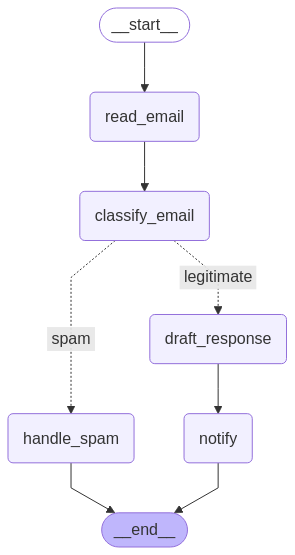

In [118]:
Image(compiled_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API))


In [119]:
# Example legitimate email
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Valentino, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

In [120]:
# Process the legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke(
    {
        "email": legitimate_email, # invoke the graph with the email
        "verbose": True,  # enable verbose output
    }
)


Processing legitimate email...
Mailbot is processing an email from john.smith@example.com with subject: Question about your services

Hi boss, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: Relational

I've prepared a draft response for your review:
--------------------------------------------------
Dear Mr. Smith,

Thank you for your email and your interest in our consulting services. I appreciate the referral from your colleague. I would be delighted to schedule a call with you next week to discuss our offerings in more detail.

Please let me know your availability, and I will do my best to accommodate it. I look forward to our conversation.

Best regards,
Mr. Valentino



In [121]:
legitimate_result

{'email': {'sender': 'john.smith@example.com',
  'subject': 'Question about your services',
  'body': "Dear Mr. Valentino, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"},
 'email_category': 'Relational',
 'spam_reason': "This email does not exhibit any characteristics of spam. It has a clear subject line, a polite greeting, and a specific request for information. It also includes the sender's name and a reference to a mutual connection.",
 'is_spam': False,
 'draft': 'Dear Mr. Smith,\n\nThank you for your email and your interest in our consulting services. I appreciate the referral from your colleague. I would be delighted to schedule a call with you next week to discuss our offerings in more detail.\n\nPlease let me know your availability, and I will do my best to accommodate it. I look forward to our conversation.\n\nBest regards,\nMr. Valentino',
 'verbose': True}

In [122]:
# Process the legitimate email
print("\nProcessing legitimate email...")
illegitimate_result = compiled_graph.invoke(
    {
        "email": spam_email, # invoke the graph with the email
        "verbose": True,  # enable verbose output
    }
)


Processing legitimate email...
Mailbot is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Mailbot has identified the email as spam. Reason: The email is offering an unsolicited large sum of money, asking for personal bank details, and requesting a processing fee, which are all common spam indicators.
The email has been moved to the spam folder.


In [123]:
illegitimate_result


{'email': {'sender': 'winner@lottery-intl.com',
  'subject': 'YOU HAVE WON $5,000,000!!!',
  'body': 'CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100.'},
 'email_category': 'Spam',
 'spam_reason': 'The email is offering an unsolicited large sum of money, asking for personal bank details, and requesting a processing fee, which are all common spam indicators.',
 'is_spam': True,
 'verbose': True}

In [124]:
legitimate_emails = [
    {
        "sender": "sarah.johnson@acme-corp.com",
        "subject": "Meeting agenda for Thursday",
        "body": "Hi team, Attached is the agenda for our quarterly review meeting on Thursday at 2 PM. Please review the attached documents before we meet. Let me know if you have any questions. Best, Sarah",
        "is_spam": False,
        "category": "Administrative"
    },
    {
        "sender": "tech-support@cloudservices.net",
        "subject": "Your support ticket #45928 has been resolved",
        "body": "Dear valued customer, We're pleased to inform you that your recent support ticket regarding login issues has been resolved. If you continue to experience problems, please reply to this email with ticket #45928 in the subject line. Thank you for your patience. - Cloud Services Support Team",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "notifications@linkedin.com",
        "subject": "Michael Chen has endorsed you for Project Management",
        "body": "Hi Alex, Michael Chen has endorsed you for Project Management on LinkedIn. View your profile to see your endorsements and send a thank you note to Michael.",
        "is_spam": False,
        "category": "Relational"
    },
    {
        "sender": "reservation@grandhotel.com",
        "subject": "Confirmation: Your stay on March 5-7, 2025",
        "body": "Dear Ms. Williams, This email confirms your reservation at Grand Hotel for March 5-7, 2025. Check-in: 3 PM, Check-out: 11 AM. Reservation #: GH-789456. We look forward to welcoming you. For changes, please call 555-123-4567. Sincerely, Grand Hotel Reservations",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "david.wilson@partnercompany.org",
        "subject": "Proposal draft and timeline",
        "body": "Hi Jessica, As discussed in our call yesterday, I've attached the draft proposal and project timeline for your review. Please let me know if you'd like any changes before we present this to the board next week. Regards, David",
        "is_spam": False,
        "category": "Relational"
    },
    {
        "sender": "newsletter@industry-insights.com",
        "subject": "March 2025 Newsletter: Industry Trends and Analysis",
        "body": "Industry Insights Newsletter - March 2025 | Featured Article: The Impact of AI on Manufacturing | Upcoming Webinar: Supply Chain Optimization Strategies | Market Analysis: Q1 Reports | To unsubscribe, click here",
        "is_spam": False,
        "category": "Marketing"
    },
    {
        "sender": "laura.santos@freelance-writer.me",
        "subject": "Invoice #113 for content writing services",
        "body": "Dear Mr. Reynolds, Please find attached invoice #113 for the content writing services provided in February 2025. Payment terms are net 30 days as per our agreement. Thank you for your business. Best regards, Laura Santos",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "no-reply@amazon.com",
        "subject": "Your Amazon order #112-7366425-8795621 has shipped",
        "body": "Your package is on its way! Your order of 'Wireless Headphones' has shipped and is expected to arrive on Tuesday, April 2. Track your package: https://amazon.com/track/112-7366425-8795621",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "alumni@university.edu",
        "subject": "Annual Alumni Fundraising Event - Save the Date",
        "body": "Dear Alumni, We're excited to announce our Annual Fundraising Gala will take place on May 15, 2025, at the University Grand Hall. This year's theme is 'Building Tomorrow's Leaders'. Early bird tickets available until April 10. More details to follow. University Alumni Association",
        "is_spam": False,
        "category": "Marketing"
    },
    {
        "sender": "hr@currentemployer.com",
        "subject": "Important: Benefits enrollment period ending soon",
        "body": "Reminder: The annual benefits enrollment period ends on April 10, 2025. Please log in to the HR portal to review and confirm your selections for the upcoming fiscal year. If no changes are made, your current selections will roll over. Human Resources Department",
        "is_spam": False,
        "category": "Administrative"
    }
]

spam_emails = [
    {
        "sender": "security-alert@bankofamerica-secure.info",
        "subject": "Urgent: Your account has been limited",
        "body": "Dear valued customer, We have detected suspicious activity on your account. Your access has been limited for security reasons. Please verify your identity by clicking this link immediately: http://secure-bankofamerica.info/verify",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "employment@career-opportunity.net",
        "subject": "Make $5000/week working from home!",
        "body": "AMAZING OPPORTUNITY! We're looking for serious people who want to earn $5000+ per week working just 2 hours per day from home! No experience needed! Limited positions available! Reply NOW with your name and phone number to secure your spot!",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "prince.nelson@royalfamily-intl.org",
        "subject": "Confidential Business Proposal",
        "body": "Dear Friend, I am Prince Nelson from the Royal Family of Wakanda. I need to transfer $25,000,000 out of my country and require your assistance. In return, you will receive 30% of the funds. Please reply with your bank details to proceed with this transaction. Regards, Prince Nelson",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "billing@netflix-accounts.com",
        "subject": "Netflix Payment Failed - Update Information",
        "body": "Dear Customer, Your Netflix payment method has expired. To avoid service interruption, please update your payment information immediately: http://netflix-account-verify.com/login",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "pharmacy-discounts@medstore24.biz",
        "subject": "70% OFF Premium Medications - No Prescription Needed!",
        "body": "HUGE PHARMACEUTICAL SALE! Get premium medications at 70% OFF regular prices! No prescription required! Overnight shipping available! Viagra, Cialis, Weight Loss Pills, Pain Relief, and more! Order now at www.medstore24.biz",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "customer-service@apple.id-verify.com",
        "subject": "Your Apple ID was used to sign in on a new device",
        "body": "Dear Customer, Your Apple ID was recently used to sign in on an unknown device in Kyiv, Ukraine. If this wasn't you, your account may be compromised. Secure your account now: https://apple-id-verification.com/secure",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "irs.refunds@tax-return-service.org",
        "subject": "IRS: You have a tax refund pending",
        "body": "ATTENTION: The Internal Revenue Service has calculated your tax return and determined you are eligible for an additional refund of $1,427.89. To claim your refund, click here to verify your identity and provide your direct deposit information: https://irs-tax-refunds.org/claim",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "james.wilson@businessproposal.co",
        "subject": "Re: Our discussion last week",
        "body": "Hello, Following up on our discussion last week regarding the investment opportunity. As I mentioned, this is a limited-time offer with 300% guaranteed returns within 3 months. Minimum investment is only $1000. Let me know if you're ready to proceed. James Wilson, Investment Specialist",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "track-delivery@fedex-shipping.info",
        "subject": "FedEx: Your package delivery status",
        "body": "Notification: We attempted to deliver your package today but were unable to due to an incorrect address. To reschedule delivery, please confirm your details here: http://fedex-delivery-reschedule.info/form. Reference: FDX-78542136",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "support@microsoft-security-team.net",
        "subject": "Critical Windows Security Alert - Immediate Action Required",
        "body": "WARNING: Your Windows computer has been infected with dangerous malware that is stealing your personal information. Our security scan detected 13 viruses on your system. Download and run our free security tool immediately to remove these threats: www.microsoft-security-scan.net/download",
        "is_spam": True,
        "category": "Spam"
    }
]

In [125]:
def evaluate_email_classifications(ground_truth, predictions):
    """
    Evaluate email classification performance.
    
    Parameters:
    - ground_truth: List of email dictionaries with true labels
    - predictions: List of state dictionaries with model predictions
    
    Returns:
    - Dictionary containing evaluation metrics
    """
    # Extract true values and predictions
    true_spam = [email["is_spam"] for email in ground_truth]
    pred_spam = [pred["is_spam"] for pred in predictions]
    
    # Calculate spam detection metrics
    spam_f1 = f1_score(true_spam, pred_spam)
    return spam_f1


# Combine legitimate and spam emails
ground_truth = legitimate_emails + spam_emails

predictions = []
for email in tqdm(ground_truth):

    response = compiled_graph.invoke({"email": email, "verbose": False})
    predictions.append({"is_spam": response["is_spam"]})

# Evaluate
results = evaluate_email_classifications(ground_truth, predictions)

100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


In [127]:
print(f"F1 Score for spam detection: {results:.2f} with model '{model.model_id}'")


F1 Score for spam detection: 0.89 with model 'watsonx/ibm/granite-3-2-8b-instruct'


Analysis:

Baseline:
Temperature = 0.7
max_new_tokens = 300
F1 Score for spam detection: 0.89 with model 'watsonx/ibm/granite-3-2-8b-instruct'

iteration 1:
Temperature = 1.0
max_new_tokens = 100

Lowering temperature toward 0.0 should make the “is_spam” decision more consistent and less prone to hallucination; raising toward 1.0 should inject more creativity in the draft responses but can reduce classification reliability.

max_new_tokens for classification prompts can be set quite low (e.g. 50–100 tokens) since we only need a brief decision + rationale; reducing this can shave latency and keep the model focused.

F1 Score for spam detection: 0.82 with model 'watsonx/ibm/granite-3-2-8b-instruct'

iteration 2:
Temperature = 0.3
max_new_tokens = 100

F1 Score for spam detection: 0.89 with model 'watsonx/ibm/granite-3-2-8b-instruct'

Iteration 3: 

Adding top_p to try and further concentrate the model on high‑probability tokens, improving classification consistency.

Temperature = 0.3
top_p = 0.8
max_new_tokens = 100

F1 Score for spam detection: 0.82 with model 'watsonx/ibm/granite-3-2-8b-instruct'


Iteration 4:
Temperature = 0.1
top_p = 0.5
max_new_tokens = 50

F1 Score for spam detection: 0.89 with model 'watsonx/ibm/granite-3-2-8b-instruct'

Final thoughts:
 My tuning of the hyperparameters showed that temperature is the most critical lever for classification consistency—keeping it in the 0.1–0.3 range reliably hit our 0.89 F1 ceiling. I could comfortably cut max_new_tokens to 50–100 for faster responses without hurting accuracy, and introducing top_p didn’t improve (and sometimes hurt) spam detection unless temperature is driven near zero. 